# Introduction to NEST

The NEST simulator recreates the electrophysiological experiment in the laboratory. Inside this framework, a neural system has a collection of **Nodes** and **Connections** which are defined by the user's code. **Nodes** represent *neurons* and *devices* whereas **Connections** represent *synapses*.

To measure activity of a neuron or of a neural system, you may connect *devices* to them such as a voltmeter, a spike generator, etc. These instruments are usually present in all electrophysiological experiments! In NEST, the readings of these devices are written on to memory and can be accessed and plotted after the simulation is finished.

PyNEST is a python library that provides the instructions for the python interpreter to interact with the NEST simulator which is originally written in the C++ programming language.

In the following tutorial, we will cover the following aspects of the library:

* Creating nodes
* Connecting nodes with default and specific connectivities
* Performing simulations 
* Extracting and plotting measurements

Before we start, let's import the necessary libraries.

In [7]:
import nest
import matplotlib.pyplot as plt
%matplotlib inline

In [129]:
plt.rcParams['figure.dpi'] = 300.0 # modifying dots per inch for figures

Please note that if you need to import other packages like scipy or scikit-learn, you should import these before nest.

For NEST to simulate different experiments, its kernel (core functionality) needs to be reseted for every new simulation. Please remember to run this code before running each simulation.

In [118]:
nest.ResetKernel() # reset simulation kernel

### Creating nodes and connections with default values

Conceptually, neural networks consists of neurons and connections. Nodes can be *neurons*, *sub-networks* or *devices* inside the NEST framework. We will use devices to stimulate neurons and to measure their membrane potential. Sub-networks, on the other hand, are arrangements of neurons whose parameters may be modified as a group. We will look at sub-networks in the following lectures. 

For now, we will focus on constructing a leaky integrate-and-fire (LIF) neuron with delta-shaped synaptic currents:

<img src="https://icwww.epfl.ch/~gerstner/SPNM/img378.gif">

In this figure, a delta-shaped pulse $\delta(t-t_j^f)$ from neuron $j$ is being transmitted along its axon until it reaches neuron $i$'s dendrites through a synapse.

Synapses are modelled as low-pass RC circuit filters which output a current $\alpha(t-t_j^f)$. These presynaptic currents reach the soma as an input current $I(t)$ which charges the capacitor $C$ (integration) while some of it leaks out through the resistance $R$. The electrical components here represent a circuit modelization of the biological mechanisms happening at the synapse and the soma.

In this model, the membrane's potential is represented by capacitor $C$ such that when it has enough charge and reaches the threshold potential $\vartheta$, a spike $\delta(t-t_i^f)$ is generated and transmitted.

In [119]:
# create LIF neuron with delta-shaped synaptic currents
neuron=nest.Create('iaf_psc_delta')

Parameters of this neuron can be accessed with the `GetStatus()` function:

In [120]:
# get the parameter list and values of a node
nest.GetStatus(neuron)

({'archiver_length': 0,
  'beta_Ca': 0.001,
  'C_m': 250.0,
  'Ca': 0.0,
  'E_L': -70.0,
  'element_type': <SLILiteral: neuron>,
  'frozen': False,
  'global_id': 1,
  'I_e': 0.0,
  'local': True,
  'local_id': 1,
  'model': <SLILiteral: iaf_psc_delta>,
  'node_uses_wfr': False,
  'parent': 0,
  'post_trace': 0.0,
  'recordables': (<SLILiteral: V_m>,),
  'refractory_input': False,
  'supports_precise_spikes': False,
  'synaptic_elements': {},
  't_ref': 2.0,
  't_spike': -1.0,
  'tau_Ca': 10000.0,
  'tau_m': 10.0,
  'tau_minus': 20.0,
  'tau_minus_triplet': 110.0,
  'thread': 0,
  'thread_local_id': -1,
  'V_m': -70.0,
  'V_min': -1.7976931348623157e+308,
  'V_reset': -70.0,
  'V_th': -55.0,
  'vp': 0},)

From this list, please note the values of `C_m`, `E_L`, `tau_m`, `V_m`, `V_reset` and `V_th`. The units of each parameter is not represented but are standarized to `uF` (microfaraday), `ms` (miliseconds) and `mV` (milivolts). 

You might have noticed that there is no parameter for the membrane resistance `R_m` as shown in the previous figure. **Can you think of an explanation for this?**

In [131]:
# retrieve a particular set of parameters
nest.GetStatus(neuron,['V_reset','V_th'])

((-70.0, -55.0),)

In [121]:
# create a spike generator
spikegenerator=nest.Create('spike_generator')

Parameters of this device can be modified using the `SetStatus()` function:

In [122]:
# modify spike generation to values 15 and 45 ms
nest.SetStatus(spikegenerator,{'spike_times': [15.,45.]})

Devices also have various parameters depending on their usage. For this particular device, we should only worry about the spike and time related parameters.

In [123]:
nest.GetStatus(spikegenerator)

({'allow_offgrid_spikes': False,
  'allow_offgrid_times': False,
  'element_type': <SLILiteral: stimulator>,
  'frozen': False,
  'global_id': 2,
  'local': True,
  'local_id': 2,
  'model': <SLILiteral: spike_generator>,
  'node_uses_wfr': False,
  'origin': 0.0,
  'parent': 0,
  'precise_times': False,
  'shift_now_spikes': False,
  'spike_multiplicities': array([], dtype=int64),
  'spike_times': array([15., 45.]),
  'spike_weights': array([], dtype=float64),
  'start': 0.0,
  'stop': 1.7976931348623157e+308,
  'supports_precise_spikes': False,
  'thread': 0,
  'thread_local_id': -1,
  'vp': 0},)

In [124]:
# create a voltmeter
voltmeter=nest.Create('voltmeter')

Let's connect the spike generator and the voltmeter to the neuron.

In [125]:
# connect spike generator and voltmeter to the neuron
nest.Connect(spikegenerator, neuron)
nest.Connect(voltmeter, neuron)

These connectivities are not reflected in the node's parameter list but you may use `GetConnections()` function to review them. The return value of this function is a tuple that contains a list in which the first and second values are the global source and target node identifiers (ids) in the simulation. These parameters are shown in the node's parameter list.

In [126]:
# get status of connections of a given node
nest.GetConnections(spikegenerator)

(array('l', [2, 1, 0, 0, 0]),)

**Can you grab the value of the target id from the previous output?**

In [127]:
#nest.GetConnections(spikegenerator)[0][1] (to be removed)

Simulate for 100 ms and observe the results

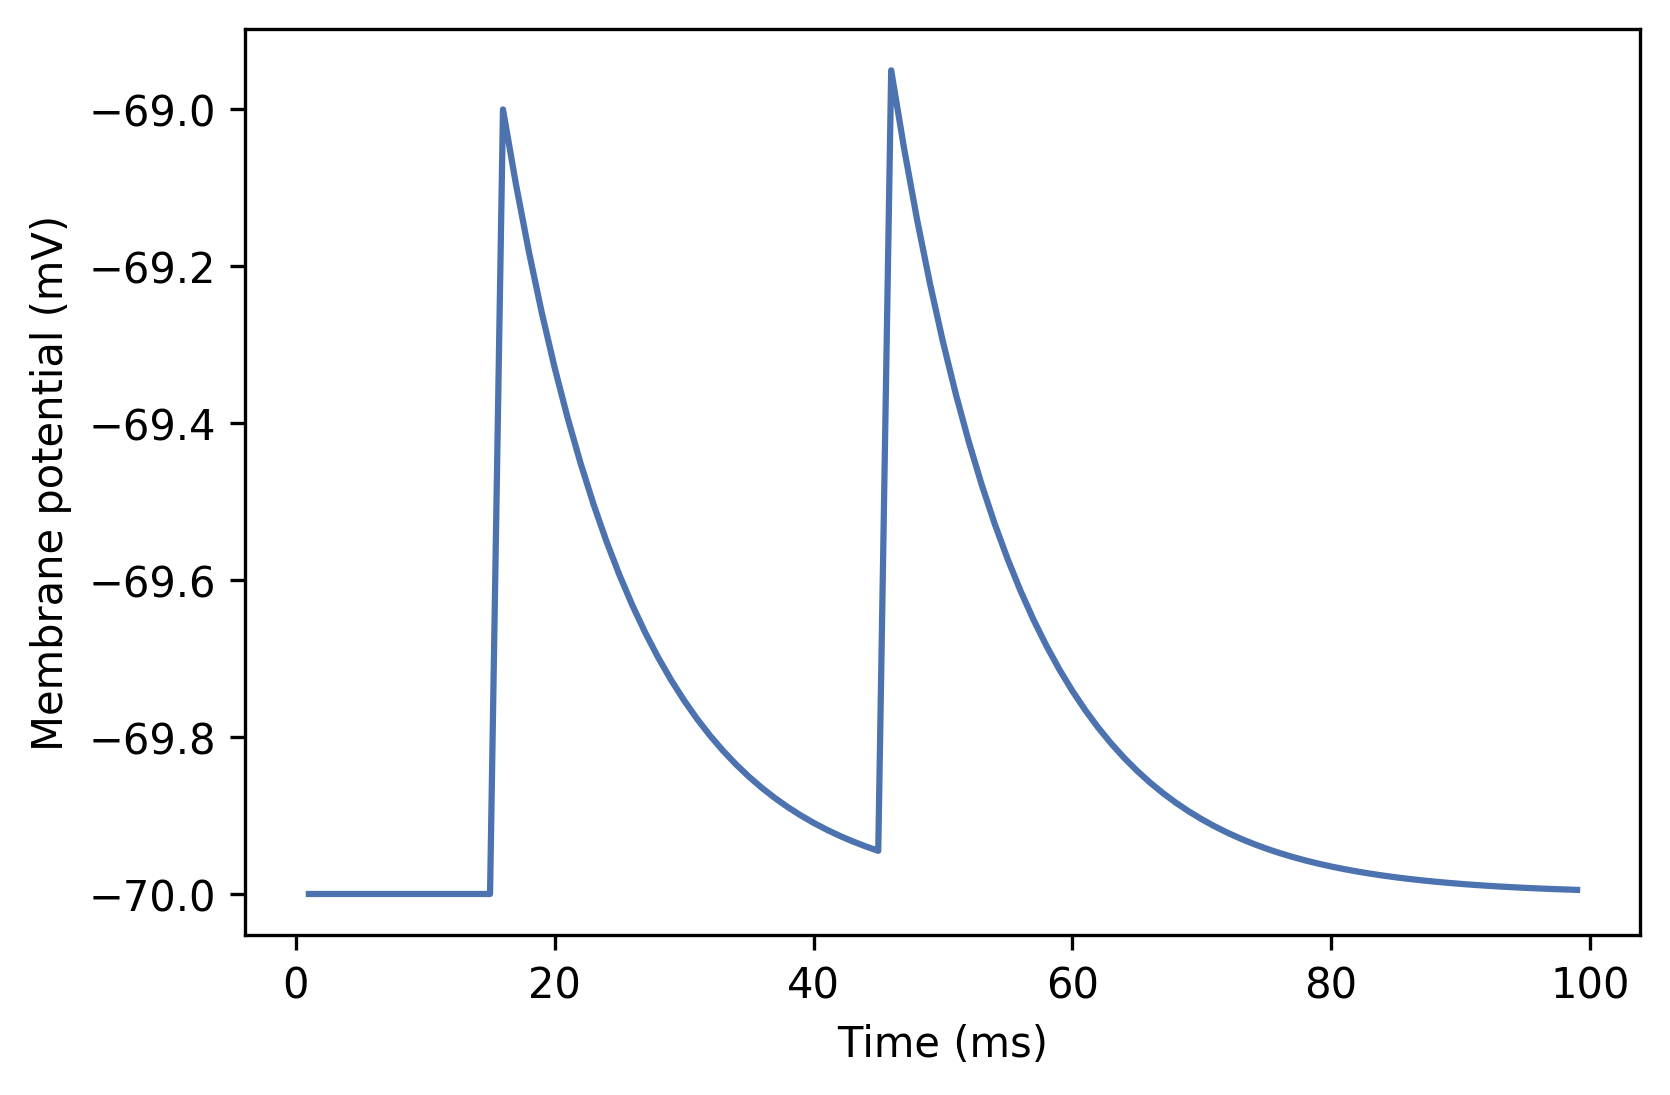

In [128]:
### run simulation for 100ms
nest.Simulate(100.)

# read out recording time and voltage from voltmeter (check the parameter list!)
times=nest.GetStatus(voltmeter)[0]['events']['times']
voltage=nest.GetStatus(voltmeter)[0]['events']['V_m']

# plot results
plt.plot(times,voltage)
plt.xlabel('Time (ms)');
plt.ylabel('Membrane potential (mV)')
plt.show()

**What can we observe here? Are these neuron spikes?**

### Connecting nodes with different inputs

In [132]:
nest.ResetKernel() # reset simulation kernel

Rate of neuron stimulated with constant input:  0.0
Rate of neuron stimulated with Poisson input:  0.0


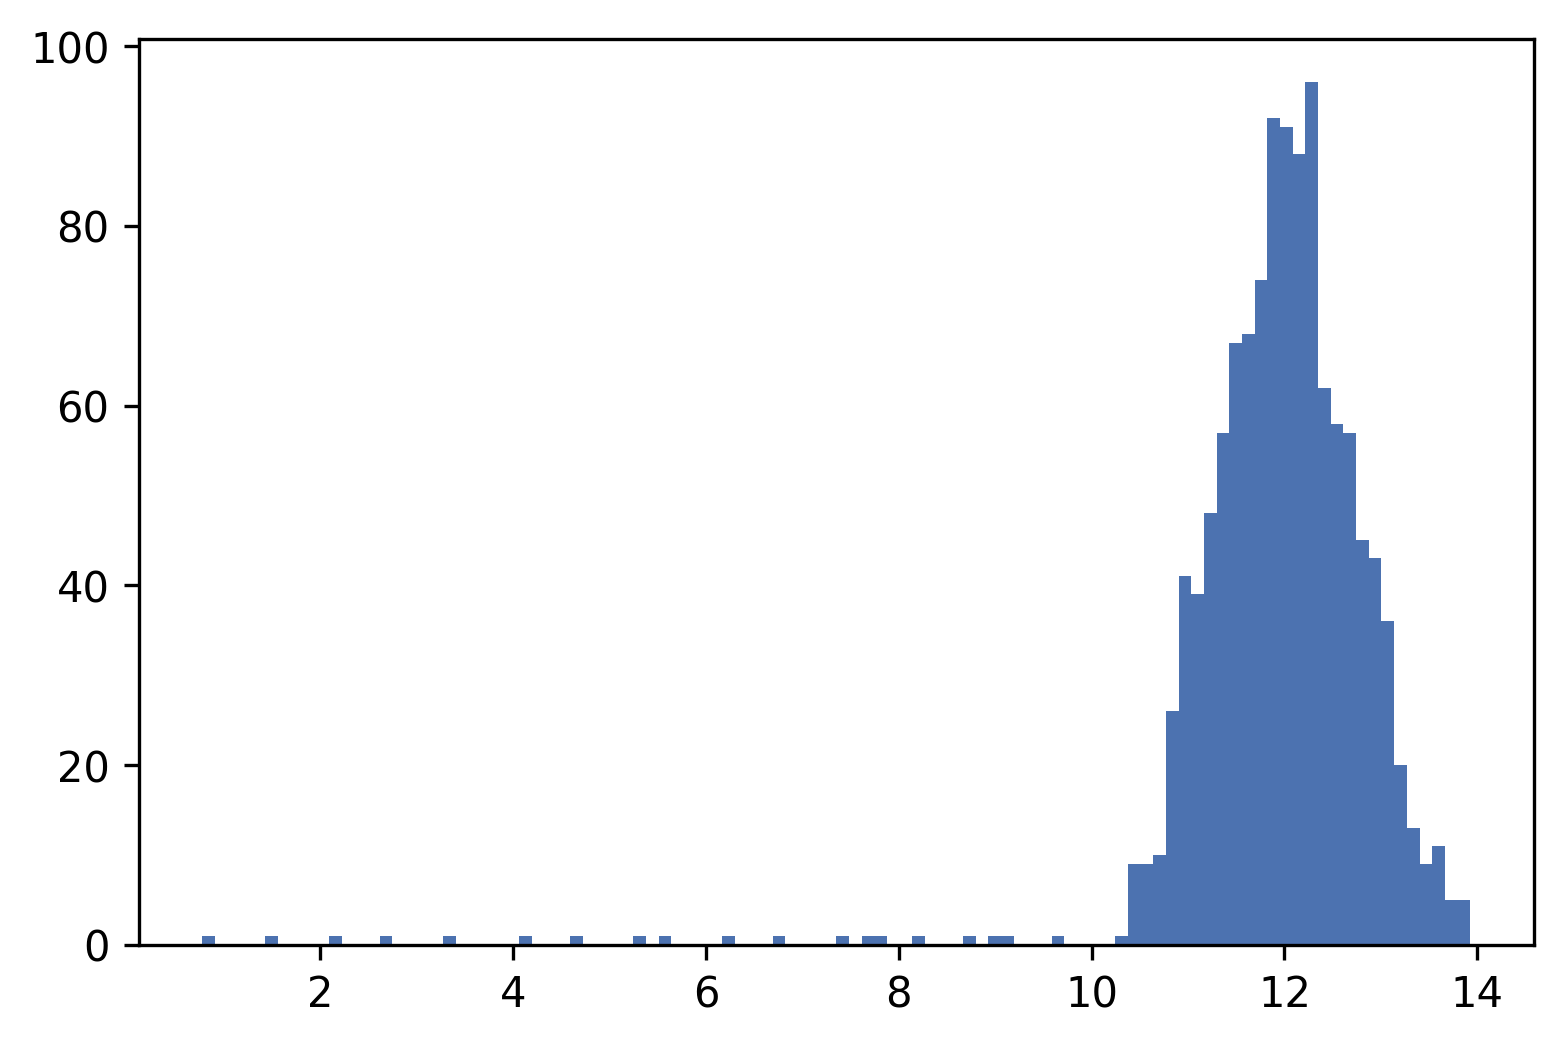

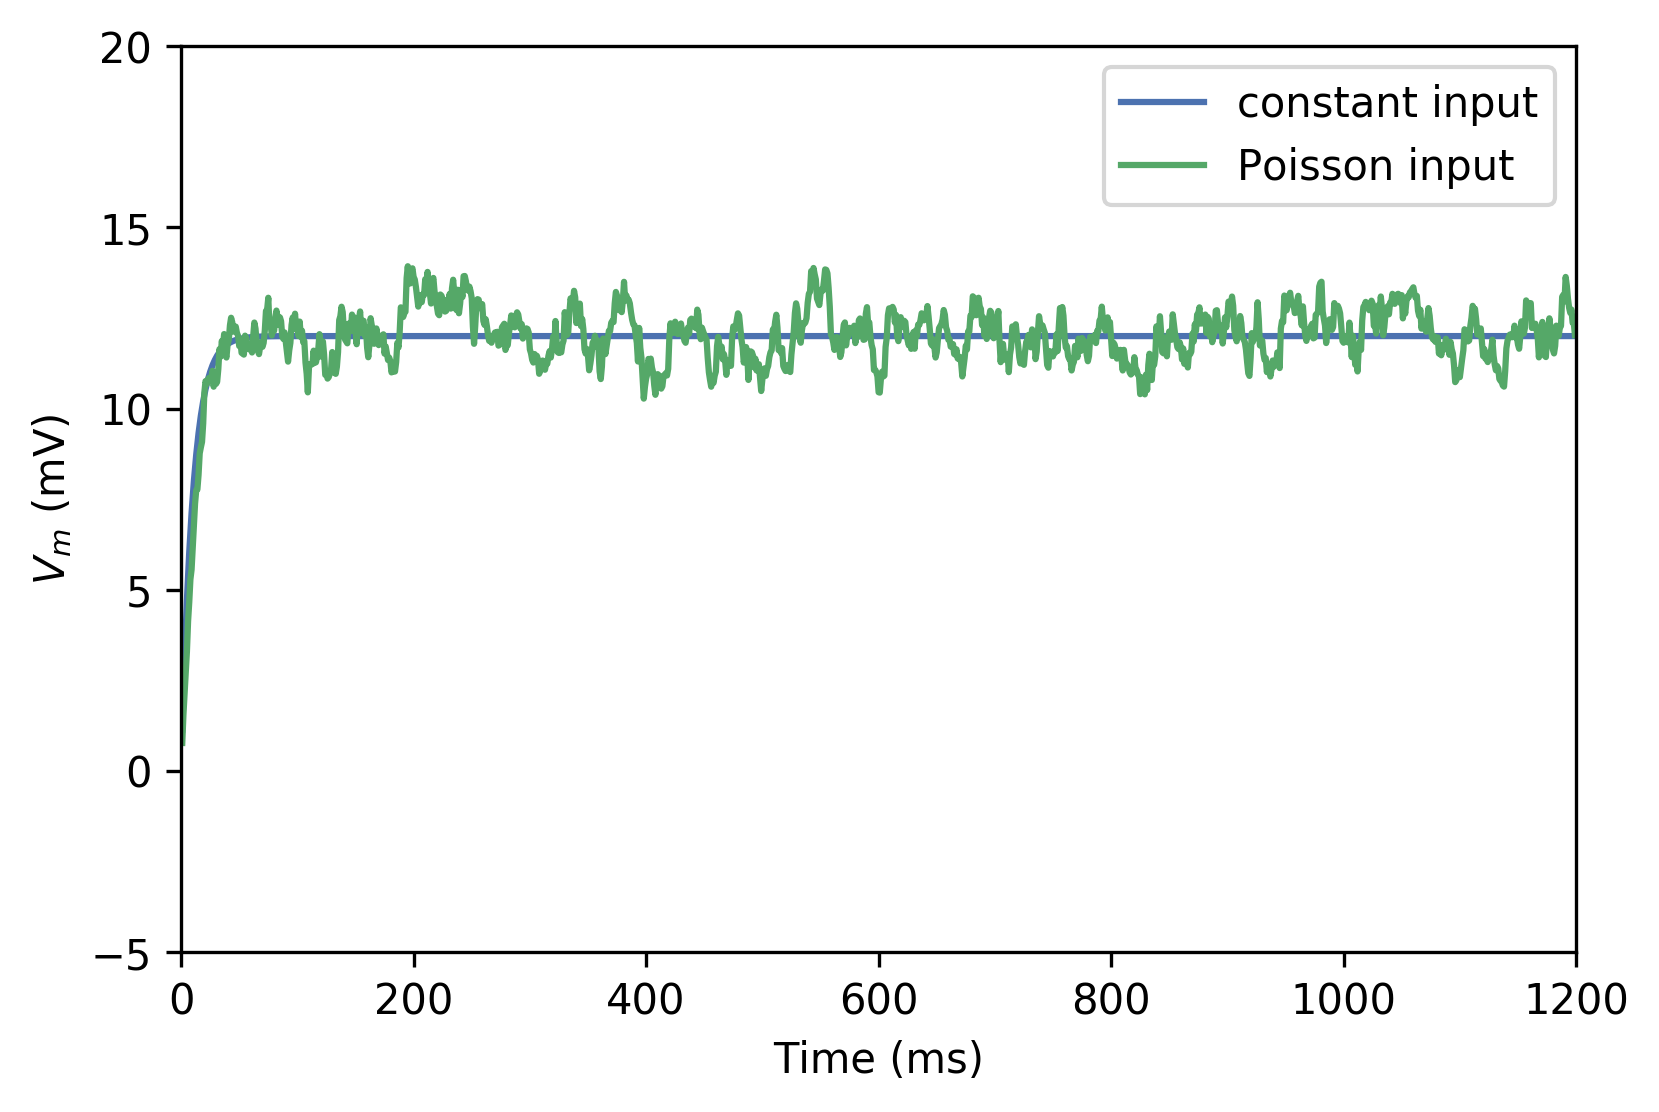

In [133]:
'''Probability density function and firing rates of neurons supplied
with constant and Poisson input.
Two neurons are created. One is fed with a constant input current.
The other one receives a Poisson spike train with the same mean
strength as constant input current. By increasing the synaptic
strength J, the neuron receiving Poisson input will be in different
firing rate regimes. For example: J=0.08 (no firing), J=0.09
(irregular firing), J=0.11 (regular firing)
'''

# simulation time
T = 1.2e3 # (ms)
# firing rate of external Poisson source
nu_ext = 15e3 # (Hz)
# synaptic weight
J = 0.08 # (mV)
# delay
d = 0.1 # (ms)
# membrane potential capacitance
C = 250.0 # (pF)
# mean input in pA
mu = J*1e-3*nu_ext*C
# external current
I_ext = mu

# neuron parameter
neuron_params = {
    'C_m': C, # (pF)
    'E_L': 0., # (mV)
    'I_e': 0.0, # (pA)
    'V_m': 0., # (mV)
    'V_reset': 0., # (mV)
    'V_th': 15., # (mV)
    't_ref': 2.0, # (ms)
    'tau_m': 10.0, # (ms)
}

nest.ResetKernel() # reset simulation kernel

# set default neuron parameters
nest.SetDefaults('iaf_psc_delta', neuron_params)

# create two 'iaf_psc_delta' neurons
neurons = nest.Create('iaf_psc_delta', 2)
# supply the first neuron with the constant current I_ext
nest.SetStatus([neurons[0]], {'I_e': I_ext})

# create Poisson generator with rate nu_ext
poisson_generator = nest.Create('poisson_generator',
                                params={'rate': nu_ext})

# create two multimeter to record membrane potential of the neurons
multimeters = nest.Create('multimeter', 2)
# set the multimeters to record membrane potentials
nest.SetStatus(multimeters, {'record_from': ['V_m']})

# create two spike detectors to record spikes of neurons
spikedetectors = nest.Create('spike_detector', 2)
# set the spike detectors to record spike times and neuron identifiers, but not to record from file
nest.SetStatus(spikedetectors, [{'withtime': True,
                                 'withgid': True,
                                 'to_file': False}])

# connect devices to neurons
nest.Connect(poisson_generator, [neurons[1]], syn_spec={'weight':J, 'delay':d})
nest.Connect(multimeters, neurons, 'one_to_one')
nest.Connect(neurons, spikedetectors, 'one_to_one')

# simulate
nest.Simulate(T)

# read out data
# initialization of lists containing membrane potentials and times as
# well as spike times of both neurons
V_mem = []
times = []
spikes = []
for i in range(2):
    data = nest.GetStatus([multimeters[i]])[0]['events']
    V_mem.append(data['V_m'])
    times.append(data['times'])
    spikes.append(nest.GetStatus([spikedetectors[i]])[0]['events']['times'])

# calculate and print firing rate of neurons
rate = float(len(spikes[0]))/T*1e3
print('Rate of neuron stimulated with constant input: ', rate)
rate = float(len(spikes[1]))/T*1e3
print('Rate of neuron stimulated with Poisson input: ', rate)

## plot results
# plot histogram of membrane potentials of noise driven neuron
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(111)
ax1.hist(V_mem[1], 100)

# plot traces of membrane potential
fig2 = plt.figure(2)
plt.plot(times[0], V_mem[0], label='constant input')
plt.plot(times[1], V_mem[1], label='Poisson input')
plt.xlabel('Time (ms)')
plt.ylabel(r'$V_m$ (mV)')
plt.xlim([0., T])
plt.ylim([-5., 20.])
plt.legend()
plt.show()